In [1]:
import ast
import json
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
import json
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
import keras.backend as K

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Import vocabolary
with open('vocabolario.json', 'r') as f:
    vocab_index = json.load(f)
    
    
# Import data
df = pd.read_csv('dataset_sequence.csv', sep = ';')[['review_rating', 'review_text_token_flag_index']]
df['review_text_token_flag_index_list'] = df['review_text_token_flag_index'].apply(lambda x: ast.literal_eval(x))

# Split data in train, test and validation

Prima di procede con lo split verifico se il dataset è bilanciato o no rispetto le classi.

In [3]:
df['review_rating_01'] = df['review_rating'].apply(lambda x: 1 if x==1 else 0)
df['review_rating_01'].value_counts()

1    69157
0     6632
Name: review_rating_01, dtype: int64

Si osserva che il dataset è fortemente sbilanciato, il che potrebbe implicare una'ottima capacità di individuare review positive e una scarsa abilità ad individuare le negative. Per affrontare tale, ricorrente, problema, si prendono in considerazione quattro diverse strategie:

1. Down-sample Majority Class: dove al contrario si scelgono randomicamente without replacement esempi positivi da rimuovere per pareggiare la classe in minoranza
2. Up-sample Minority Class: dove randomicamente without replacement si pescano sample negativi fino a pareggiare le due classi
3. Rebalance che prevede di allenare il modello su più dataset bilanciati. In particolare, in questo caso, si creano 10 dataset di 6632 unità negative e altrettante 6632 positive scelte in modo random, così che almeno tutti i campioni positivi siano visti dai modelli. Si procede quindi con *voting procedure* rispetto alle predizioni dei 10 modelli per predire la classe definitiva.
4. Rebalancing in fase di K-fold


__Prima di procedere con le operazioni creiamo il validation set composto dal 10% dei nostri sample (metà negativo e metà positivo). __



In [4]:
from sklearn.utils import resample

# Separiamo le due classi
df_majority = df[df.review_rating_01==1]
df_minority = df[df.review_rating_01==0]

# Facciamo sampling senza ripetizione dalle due classi
print ("Estraiamo il 20% del totale delle reviews che corrisponde a: {}. Prendiamo la metà dal df dei positivi e l'altra metà da quello dei negativi".format(len(df)/100*10))

df_minority_sample_validation = resample(df_minority, 
                                 replace=False,     # sample with replacement
                                 n_samples=int(len(df)/100*5/2),    # to match majority class
                                 random_state=123)

df_majority_sample_validation = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=int(len(df)/100*5/2),    # to match majority class
                                 random_state=123)


df_validation = pd.concat([df_minority_sample_validation, df_majority_sample_validation])

Estraiamo il 20% del totale delle reviews che corrisponde a: 7578.9. Prendiamo la metà dal df dei positivi e l'altra metà da quello dei negativi



Procediamo con il Down-sample della Majority Class.


* Separiamo i sample delle due classi in due df
* Facciamo samplin senza reimissione così da ottenere un numero si esempi pari al numero di sample della minority class.
* Combiniamo i due dataset.

In [5]:
# Remove the items in the validation
df_majority = df_majority.drop(df_majority_sample_validation.index)
df_minority = df_minority.drop(df_minority_sample_validation.index)

In [6]:
len(df_majority)

67263

In [7]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.review_rating_01.value_counts()

1    4738
0    4738
Name: review_rating_01, dtype: int64

## Define X and Y for the training step

In [27]:
x_train = np.array(df_downsampled['review_text_token_flag_index_list'])
y_train = np.array(df_downsampled['review_rating_01'])

x_validation = np.array(df_validation['review_text_token_flag_index_list'])
y_validation = np.array(df_validation['review_rating_01'])

In [28]:
# Check the max length
max_len_seq = max([len(x) for x in x_train])
print('max len seq {}'.format(max_len_seq))
max_idx = max(vocab_index.values())
print('max id {}'.format(max_idx))

max len seq 937
max id 60841


In [29]:
# Pad the sequences
x_train_pad = sequence.pad_sequences(x_train, maxlen=max_len_seq, padding='post')
x_validation_pad = sequence.pad_sequences(x_validation, maxlen=max_len_seq, padding='post')

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

In [31]:
split_train_test = StratifiedShuffleSplit(1,test_size=0.2, random_state=123456)

for train, test in split_train_test.split(x_train_pad, y_train):
    x_train_pad_split, y_train_pad_split = x_train_pad[train], y_train[train]
    x_val_pad_split, y_val_pad_split = x_train_pad[test], y_train[test]

## Build the model

In [44]:
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.
     Computes the precision, a metric for multi-label classification of
     how many selected items are relevant.
      """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))		
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))		
    precision = true_positives / (predicted_positives + K.epsilon())		
    return precision

In [45]:
def recall(y_true, y_pred):
    """Recall metric.
 
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [46]:
callbacks = [
    TensorBoard(histogram_freq=1, batch_size=128, embeddings_freq=1),
    ReduceLROnPlateau(patience=2, verbose=1)
]

In [51]:
def build_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_idx+1, output_dim=50, input_length=max_len_seq))
    model.add(Conv1D(filters=8, kernel_size=10, padding='same', activation='relu', strides=2))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=8, kernel_size=10, padding='same', activation='relu', strides=2))
    model.add(GlobalMaxPool1D())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy', precision, recall])
    
    return model

In [67]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 937, 50)           3042100   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 937, 8)            4008      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 468, 8)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 468, 8)            648       
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 8)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                450       
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
__________

## Prova

1. buono con filters=8, window = 10, stride = 2

In [68]:
history = model.fit(x_train_pad_split, y_train_pad_split, validation_data=(x_val_pad_split, y_val_pad_split),
                    batch_size=200, validation_split=0.2, epochs=10)

Train on 7580 samples, validate on 1896 samples
Epoch 1/10
7580/7580 [==============================] - 28s 4ms/step - loss: 0.6931 - acc: 0.4991 - precision: 0.4347 - recall: 0.1692 - val_loss: 0.6903 - val_acc: 0.6150 - val_precision: 0.7165 - val_recall: 0.3826
Epoch 2/10
7580/7580 [==============================] - 26s 3ms/step - loss: 0.6666 - acc: 0.6584 - precision: 0.7886 - recall: 0.4252 - val_loss: 0.5993 - val_acc: 0.7711 - val_precision: 0.8392 - val_recall: 0.6697
Epoch 3/10
7580/7580 [==============================] - 29s 4ms/step - loss: 0.4841 - acc: 0.8385 - precision: 0.8689 - recall: 0.8002 - val_loss: 0.4124 - val_acc: 0.8518 - val_precision: 0.8806 - val_recall: 0.8144
Epoch 4/10
7580/7580 [==============================] - 30s 4ms/step - loss: 0.2437 - acc: 0.9223 - precision: 0.9079 - recall: 0.9397 - val_loss: 0.2755 - val_acc: 0.8908 - val_precision: 0.8532 - val_recall: 0.9451
Epoch 5/10
7580/7580 [==============================] - 28s 4ms/step - loss: 0.1338 

In [70]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'loss', 'acc', 'precision', 'recall'])

In [73]:
history.history['val_precision']

[0.7164918727512601,
 0.8392457675330246,
 0.8806299189978009,
 0.8532025967469196,
 0.9060670074531297,
 0.9241278619202884,
 0.9167283189950614,
 0.9186837876899333,
 0.9071850816911786,
 0.9060052069933605]

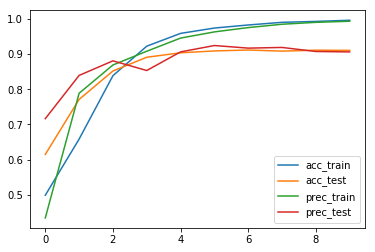

In [77]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.legend(['acc_train', 'acc_test', 'prec_train', 'prec_test'], loc='lower right')

In [32]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [78]:
model.evaluate(x_validation_pad, y_validation)

3788/3788 [==============================] - 5s 1ms/step


[0.3292366213773976,
 0.9046990496304118,
 0.5012460399454474,
 0.45895946718193786]

In [80]:
prediction = model.predict_classes(x_validation_pad)

In [85]:
from sklearn import metrics

In [86]:
prediction = model.predict_classes(x_validation_pad)
tn, fp, fn, tp = metrics.confusion_matrix(y_validation, prediction).ravel()

recall = tp/(tp+fp)
precision = tp/(tp+fn)
f1 = metrics.f1_score(y_validation,prediction)

print ('precision: {}'.format(precision), '\nrecall: {}'.format(recall), '\nf1: {}'.format(f1))

precision: 0.9149947201689546 
recall: 0.8965338851526126 
f1: 0.9056702377841651


In [81]:
model = build_model()

history = model.fit(x_train_pad, y_train, batch_size=128, epochs=10)

Epoch 1/10
13264/13264 [==============================] - 22s 2ms/step - loss: 0.6533 - acc: 0.6046 - precision: 0.7198 - recall: 0.3153
Epoch 2/10
13264/13264 [==============================] - 21s 2ms/step - loss: 0.2973 - acc: 0.8840 - precision: 0.8734 - recall: 0.8982
Epoch 3/10
13264/13264 [==============================] - 19s 1ms/step - loss: 0.1695 - acc: 0.9391 - precision: 0.9342 - recall: 0.9462
Epoch 4/10
13264/13264 [==============================] - 19s 1ms/step - loss: 0.1125 - acc: 0.9625 - precision: 0.9569 - recall: 0.9688
Epoch 5/10
13264/13264 [==============================] - 20s 1ms/step - loss: 0.0813 - acc: 0.9759 - precision: 0.9732 - recall: 0.9788
Epoch 6/10
13264/13264 [==============================] - 23s 2ms/step - loss: 0.0585 - acc: 0.9836 - precision: 0.9809 - recall: 0.9868
Epoch 7/10
13264/13264 [==============================] - 22s 2ms/step - loss: 0.0457 - acc: 0.9873 - precision: 0.9849 - recall: 0.9896
Epoch 8/10
13264/13264 [=================